<a href="https://colab.research.google.com/github/ram130849/water_body_segmentation_using_unet/blob/main/Water_Body_Segmentation_Using_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from functools import partial
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# /content/gdrive/MyDrive/water_bodies_dataset.zip
!unzip /content/gdrive/MyDrive/water_bodies_dataset.zip -d /content/gdrive/MyDrive/water_bodies_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: /content/gdrive/MyDrive/water_bodies_dataset/Water Bodies Dataset/Images

In [3]:
images_dir = '/content/gdrive/MyDrive/water_bodies_dataset/Water_Bodies_Dataset/Images'
masks_dir = '/content/gdrive/MyDrive/water_bodies_dataset/Water_Bodies_Dataset/Masks'

In [4]:
dirname, _, filenames = next(os.walk(images_dir))

In [5]:
print(len(filenames))

2841


In [11]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg'):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

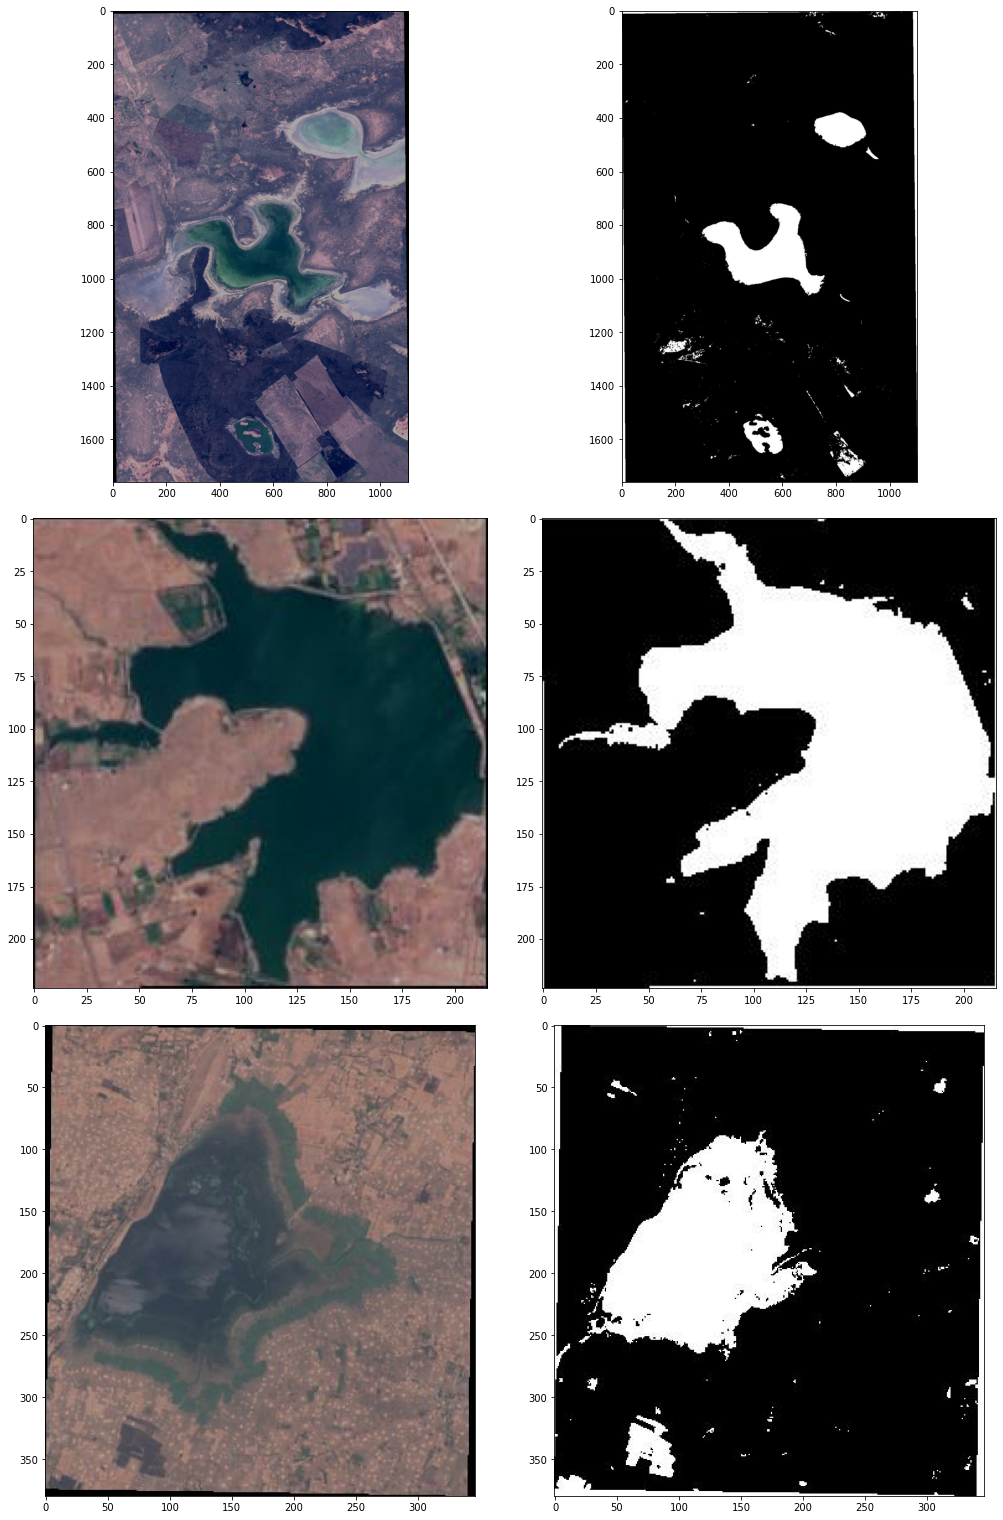

In [9]:
%matplotlib inline
n_examples = 3
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

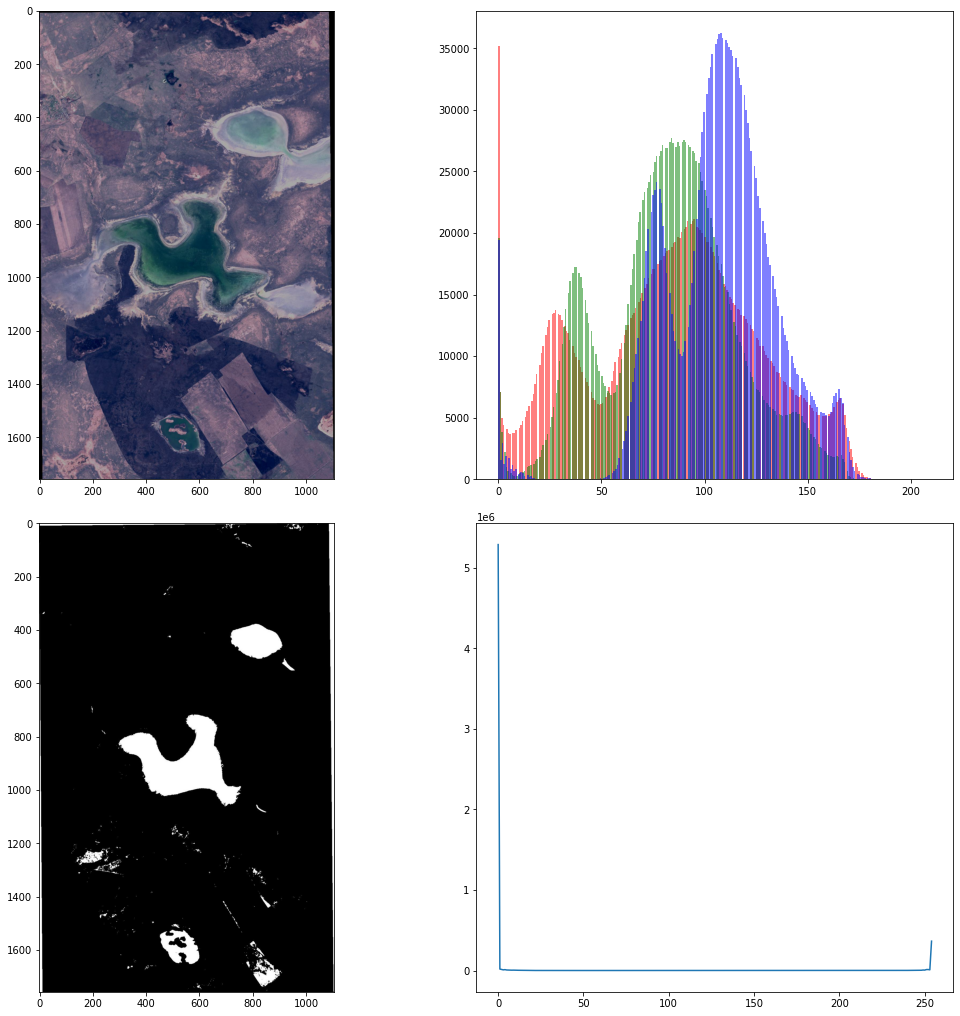

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
example_image, example_mask = examples[0]
example_image = np.array(example_image)
example_mask = np.squeeze(example_mask)
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram)
plt.show()

In [12]:
@tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

In [13]:
batch_size = 32

dataset = tf.data.Dataset.list_files(images_dir + '/*.jpg', seed=42)

test_dataset = dataset.take(300)
dataset = dataset.skip(300)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask,2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)

In [14]:
validation_dataset = dataset.take(250)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(lambda img, mask: resize_images(img, mask,2500))
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

In [15]:
train_dataset = dataset.skip(250)
train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(lambda img, mask: resize_images(img, mask,2500))
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)

In [16]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding="same", kernel_initializer='HeNormal')(input)
    x = BatchNormalization()(x, training=False)
    x = Activation("relu")(x)
   
    x = Conv2D(num_filters, 3, activation='relu', padding="same", kernel_initializer='HeNormal')(x)
    x = BatchNormalization()(x, training=False)
    x = Activation("relu")(x)

    return x

In [17]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [18]:
def decoder_block(input, skip_features, num_filters):
    x = keras.layers.UpSampling2D(size=(2, 2))(input)
    print("Before Concatenation:",x)
    x = Concatenate(axis=3)([x, skip_features])
    print("After Concatenation:",x)
    x = conv_block(x, num_filters)
    return x

In [19]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    print("S1,P1:",s1,p1)
    s2, p2 = encoder_block(p1, 64)
    print("S2,P2:",s2,p2)
    s3, p3 = encoder_block(p2, 128)
    print("S3,P3:",s3,p3)
    s4, p4 = encoder_block(p3, 256)
    print("S4,P4:",s4,p4)
    
    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    print("D1:",d1)
    d2 = decoder_block(d1, s3, 128)
    print("D2:",d2)
    d3 = decoder_block(d2, s2, 64)
    print("D3:",d3)
    d4 = decoder_block(d3, s1, 32)
    print("D4:",d4)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    print("outputs",outputs)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
input_shape = (None, None, 3)
model = unet(input_shape)
model.summary()

S1,P1: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 32), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 32), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
S2,P2: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='activation_3/Relu:0', description="created by layer 'activation_3'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
S3,P3: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='activation_5/Relu:0', description="created by layer 'activation_5'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:

In [21]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 30
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_reduce])

Epoch 1/30
2291/2291 [==============================] - 1567s 679ms/step - loss: 0.5302 - val_loss: 0.4800 - lr: 0.0010
Epoch 2/30
2291/2291 [==============================] - 239s 104ms/step - loss: 0.5308 - val_loss: 0.5033 - lr: 0.0010
Epoch 3/30
2291/2291 [==============================] - 121s 53ms/step - loss: 0.4734 - val_loss: 0.4413 - lr: 0.0010
Epoch 4/30
2291/2291 [==============================] - 70s 30ms/step - loss: 0.4533 - val_loss: 0.4300 - lr: 0.0010
Epoch 5/30
2291/2291 [==============================] - 71s 31ms/step - loss: 0.4605 - val_loss: 0.4656 - lr: 0.0010
Epoch 6/30
2291/2291 [==============================] - 70s 31ms/step - loss: 0.4659 - val_loss: 0.3668 - lr: 0.0010
Epoch 7/30
2291/2291 [==============================] - 71s 31ms/step - loss: 0.3898 - val_loss: 0.4035 - lr: 0.0010
Epoch 8/30
2291/2291 [==============================] - 71s 31ms/step - loss: 0.3741 - val_loss: 0.3992 - lr: 0.0010
Epoch 9/30
2291/2291 [==============================] - 71

1/1 [==============================] - 0s 21ms/step


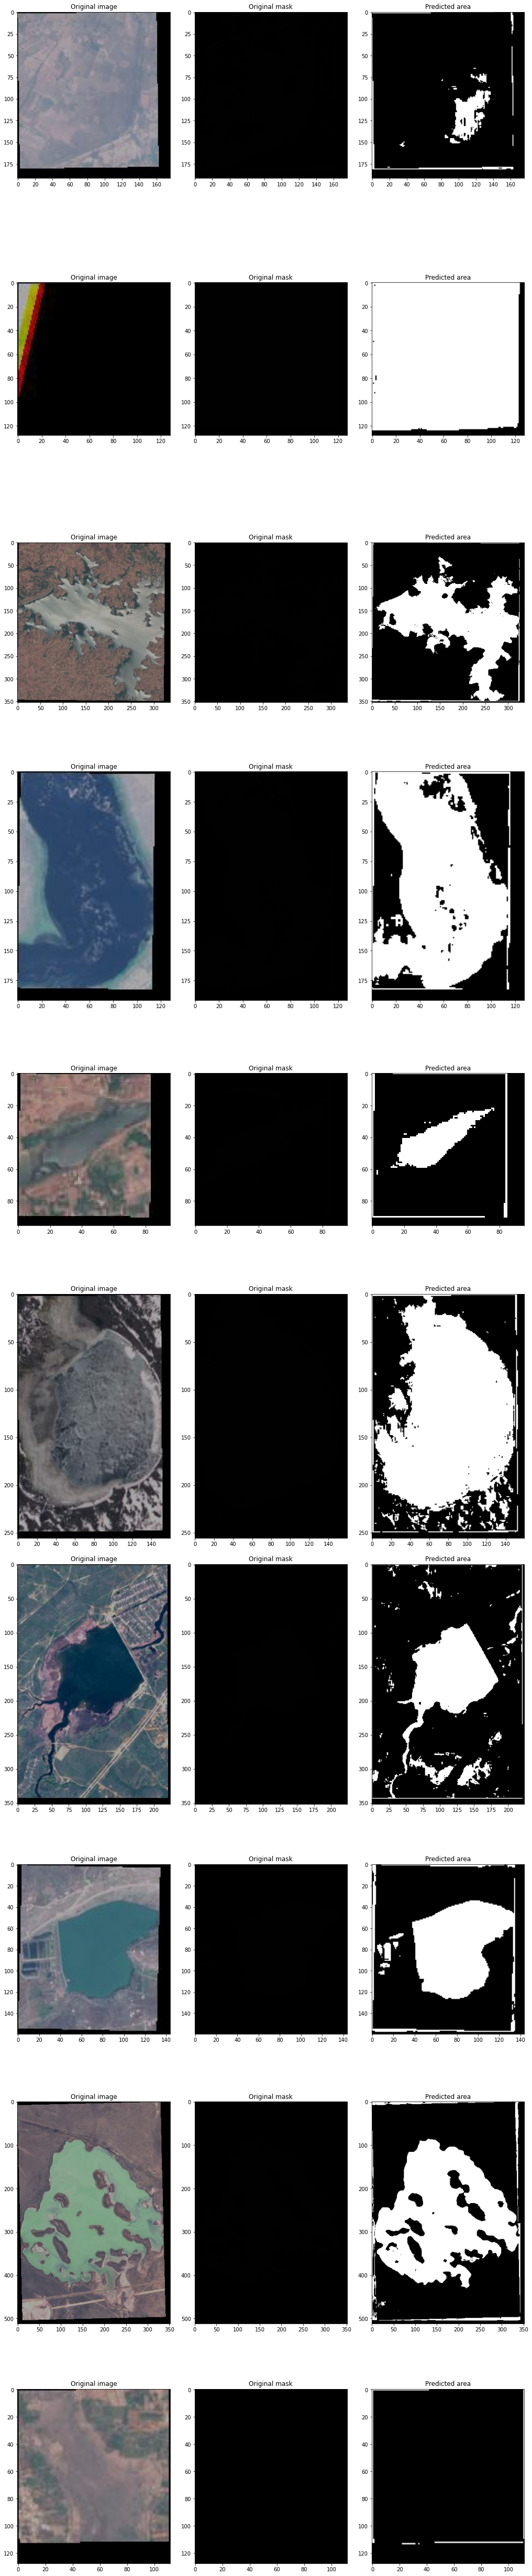

In [33]:
n_examples = 10

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(np.repeat(y_true[0], 3, axis=2))
    ax[2].set_title('Predicted area')
    ax[2].imshow(np.repeat(prediction, 3, axis=2))

In [35]:
test_set_size = 300
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true[0], prediction)
print("MeanIoU Score for Test Set:",meanIoU.result().numpy())

1/1 [==============================] - 0s 25ms/step
MeanIoU Score for Test Set: 0.72665566
